### Accent detection of english language videos using Neural Networks

This notebook is based on the accent detection dataset on kaggle (https://www.kaggle.com/datasets/rtatman/speech-accent-archive/data) and for the notebook to work, you would need to download the dataset and store it in '/kaggle/input/recordings/recordings'

In [136]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re

from tqdm import tqdm
tqdm.pandas()

In [137]:
dir = os.getcwd()+'/kaggle/input/recordings/recordings'
audio_list = os.listdir(dir)

Create a dataframe and Get the labels to the dataset

In [138]:

df = pd.DataFrame()
df['speech'] = audio_list


df['labels'] = [re.sub(r'\d+\.mp3$', '', audio) for audio in audio_list]

df.head()

,speech,labels
0,afrikaans1.mp3,afrikaans
1,afrikaans2.mp3,afrikaans
2,afrikaans3.mp3,afrikaans
3,afrikaans4.mp3,afrikaans
4,afrikaans5.mp3,afrikaans


We now make genralized classification that will help us identify the accent of the speaker into 10 categories

In [139]:
english = ['english']

indian = [
    'hindi', 'urdu', 'bengali', 'nepali', 'punjabi', 'gujarati', 'tamil',
    'telugu', 'oriya', 'marathi', 'malayalam', 'konkani',
    'kannada', 'sindhi', 'hindko','mizo'
]

east_asian = [
    'mandarin', 'cantonese', 'japanese','hainanese', 'xiang', 'wu', 'gan', 'hakka',
    'teochew', 'shan', 'taiwanese'
]
se_asian = ['vietnamese','thai', 'filipino', 'tagalog', 'indonesian', 'burmese', 'khmer',
    'malay', 'lao'
]

middle_eastern_central_asian = ['greek','farsi', 'turkish', 'hebrew', 'kurdish', 'pashto', 'tajiki',
    'kazakh', 'uzbek', 'turkmen', 'azerbaijani', 'dari', 'arabic',
    'uyghur', 'tatar', 'armenian', 'georgian']

african = [
    'amharic', 'swahili', 'somali', 'yoruba', 'zulu', 'hausa', 'igbo',
    'afrikaans', 'rwanda', 'shona', 'bambara', 'tigrigna', 'moore',
    'kikongo', 'pulaar', 'susu', 'akan', 'lusoga', 'tswana', 'bamun',
    'sara', 'wolof', 'nuer', 'dinka', 'bari', 'mandinka', 'ibibio',
    'kru', 'garifuna', 'kambaata', 'namibian', 'nandi', 'luo', 'xasonga',
    'gedeo', 'fang', 'ashanti', 'serer', 'kikuyu', 'bafang', 'hadiyya'
]

oceanian = [
    'fijian', 'pohnpeian', 'chamorro', 'carolinian', 'yapese', 'rotuman',
    'bai', 'lamotrekese', 'mortlockese', 'satawalese', 'cebuano'
]

western_european = [
    'french', 'german', 'dutch', 'portuguese', 'spanish', 'italian', 'sicilian', 'catalan'
    'irish', 'faroese', 'frisian', 'vlaams', 'luxembourgeois', 'maltese', 'basque', 'sardinian', 'bavarian'
]

northern_european = [
    'swedish', 'danish', 'norwegian', 'finnish', 'icelandic', 'estonian'
]

eastern_european = [ 'russian', 'polish', 'czech', 'slovak', 'ukrainian', 'belarusan', 'bulgarian',
    'romanian', 'serbian', 'croatian', 'bosnian', 'slovenian', 'macedonian', 'albanian'
]



We create a new column in the dataset to incorporate these classification markers

In [141]:
def get_general_label(x):
    if x in english:
        return 'English'
    if x in indian:
        return 'Indian'
    if x in east_asian:
        return 'East Asian'
    if x in se_asian:
        return 'South East Asian'
    if x in middle_eastern_central_asian:
        return 'Middle Eastern, Central Asian or Southern Europe'
    if x in african:
        return 'African'
    if x in western_european:
        return 'Western European'
    if x in northern_european:
        return 'Northern European'
    if x in eastern_european:
        return 'Eastern European'
    return 'Oceanian or Other'

df['general_label'] = df.labels.progress_apply(get_general_label)

100%|██████████| 2138/2138 [00:00<00:00, 534506.88it/s]


In [142]:
df.head()

,speech,labels,general_label
0,afrikaans1.mp3,afrikaans,African
1,afrikaans2.mp3,afrikaans,African
2,afrikaans3.mp3,afrikaans,African
3,afrikaans4.mp3,afrikaans,African
4,afrikaans5.mp3,afrikaans,African


In [143]:
df['general_label'].value_counts()

general_label
English                                             579
Western European                                    404
Middle Eastern, Central Asian or Southern Europe    242
Eastern European                                    220
Oceanian or Other                                   212
East Asian                                          133
African                                             112
Indian                                              105
South East Asian                                     82
Northern European                                    49
Name: count, dtype: int64

The dataset is a bit imbalanced and therefore we will need to use randomoversampler later to rectify this. For now we will check the distribution of the new labels in the dataset

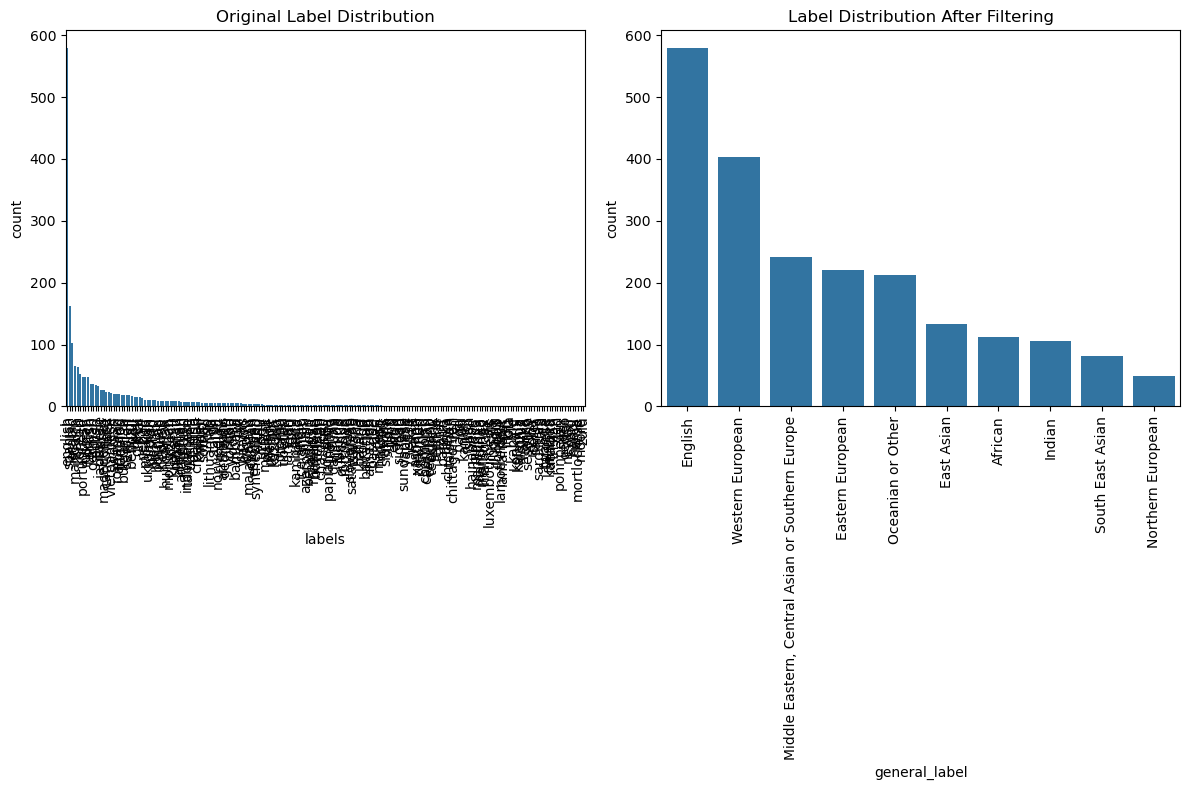

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 1-row, 2-column subplot
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# Visualize the original label distribution in the first subplot
sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index, ax=ax[0])
ax[0].set_title('Original Label Distribution')
ax[0].tick_params(axis='x', rotation=90)

# Visualize the label distribution after filtering in the second subplot
sns.countplot(data=df, x='general_label', order=df['general_label'].value_counts().index, ax=ax[1])
ax[1].set_title('Label Distribution After Filtering')
ax[1].tick_params(axis='x', rotation=90)

# Show the plots
plt.tight_layout()
plt.show()

In order to analyze the audio signals we need to convert the same into Mel-Frequency Cepstral Coefficients. Mel-Frequency Cepstral Coefficients (MFCCs) are a widely used and powerful feature extraction technique in audio signal processing, particularly in speech and music analysis. They are designed to represent the short-term power spectrum of a sound in a way that aligns with how the human auditory system perceives sound. The following steps are used to create a vector from the audio stream.

1. The audio signal is framed and windowed.
2. FFT is applied to each frame.
3. Mel filter banks are applied to the power spectrum.
4. Logarithmic compression is performed.
5. DCT is applied to obtain the static MFCCs.
6. Delta and delta-delta coefficients are computed to capture dynamic changes.
7. This results in a sequence of MFCC feature vectors for each speech utterance.

In [145]:
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

In [ ]:
features = []
for file in tqdm(df['speech']):
    file_path = os.path.join(dir, file)
    mfcc = extract_mfcc(file_path)
    features.append(mfcc)

 97%|█████████▋| 2067/2138 [02:51<00:05, 12.49it/s]

In [81]:
X = np.array(features)
y = df['general_label'].values


print("Shape of X:", X.shape) 
print("Shape of y:", y.shape)  

Shape of X: (2138, 13)
Shape of y: (2138,)


In [82]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [83]:
y_encoded

array([0, 0, 0, ..., 0, 7, 0])

In [84]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y_encoded)

# Convert the resampled encoded labels back to the original labels
y_resampled_labels = label_encoder.inverse_transform(y_resampled)

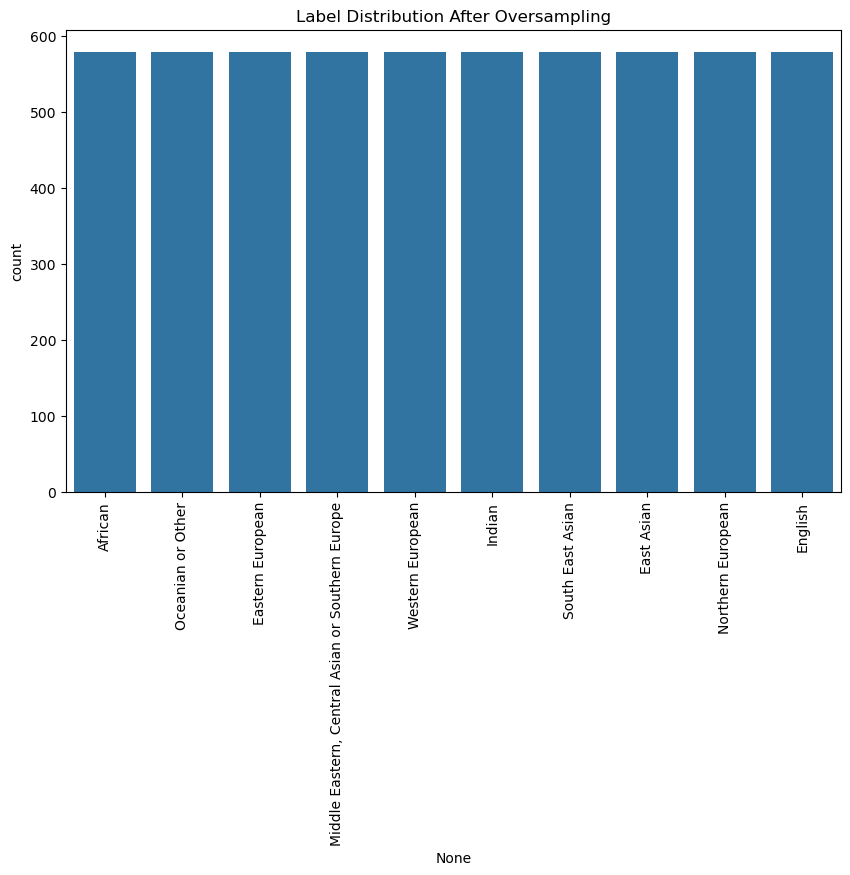

In [85]:
# Visualize the label distribution after oversampling
plt.figure(figsize=(10, 6))
sns.countplot(x=pd.Series(y_resampled_labels))
plt.title('Label Distribution After Oversampling')
plt.xticks(rotation=90)
plt.show()

In [86]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_labels, test_size=0.2, random_state=42)

# Reshape data for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Visualize the shape of training and testing data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Print the shapes of y_train and y_test
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Training data shape: (4632, 13, 1)
Testing data shape: (1158, 13, 1)
y_train shape: (4632,)
y_test shape: (1158,)


In [126]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
# Ensure the labels are encoded as integers (this should already be done)
# Using the previously encoded labels
y_train_encoded = label_encoder.transform(y_train)  # Use LabelEncoder's transform method
y_test_encoded = label_encoder.transform(y_test)

# Now, one-hot encode the labels
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

# Build the CNN model
# Hyperparameter tuning & Model improvements
from tensorflow.keras.layers import BatchNormalization

# Build the CNN model
model = Sequential()

# First convolutional layer with normalization
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Flatten the output of convolutional layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.2))
# Output layer
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model with a lower learning rate for more stable convergence
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model with early stopping to avoid overfitting


history = model.fit(X_train, y_train_encoded, epochs=150, batch_size=32, validation_data=(X_test, y_test_encoded))

E:\Users\91894\anaconda3\envs\python_ml_Data\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 11, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 11, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,042 (234.54 KB)

 Trainable params: 59,658 (233.04 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1573 - loss: 2.3591 - val_accuracy: 0.1684 - val_loss: 2.2276
Epoch 2/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2176 - loss: 2.1480 - val_accuracy: 0.1934 - val_loss: 2.1576
Epoch 3/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2697 - loss: 2.0419 - val_accuracy: 0.2617 - val_loss: 2.0512
Epoch 4/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3077 - loss: 1.9448 - val_accuracy: 0.3074 - val_loss: 1.9408
Epoch 5/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3503 - loss: 1.8632 - val_accuracy: 0.3256 - val_loss: 1.9005
Epoch 6/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3825 - loss: 1.7666 - val_accuracy: 0.3541 - val_loss: 1.8588
Epoch 7/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4048 - loss: 1.7042 - val_accuracy: 0.3895 - val_loss: 1.7520
Epoch 8/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4329 - loss: 1.6166 - val_accu

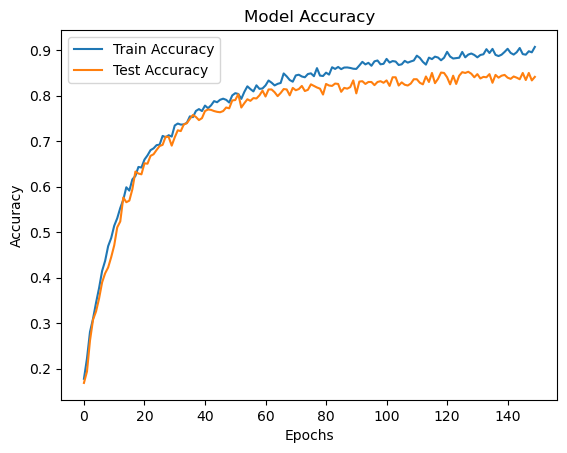

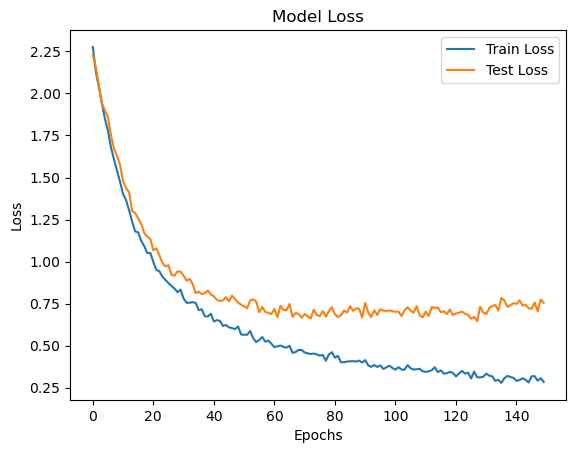

In [127]:
# Visualize the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [123]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.8261 - loss: 0.6911
Test Loss: 0.752149760723114
Test Accuracy: 0.8100172877311707


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predicted Accuracy: 0.7746113989637305


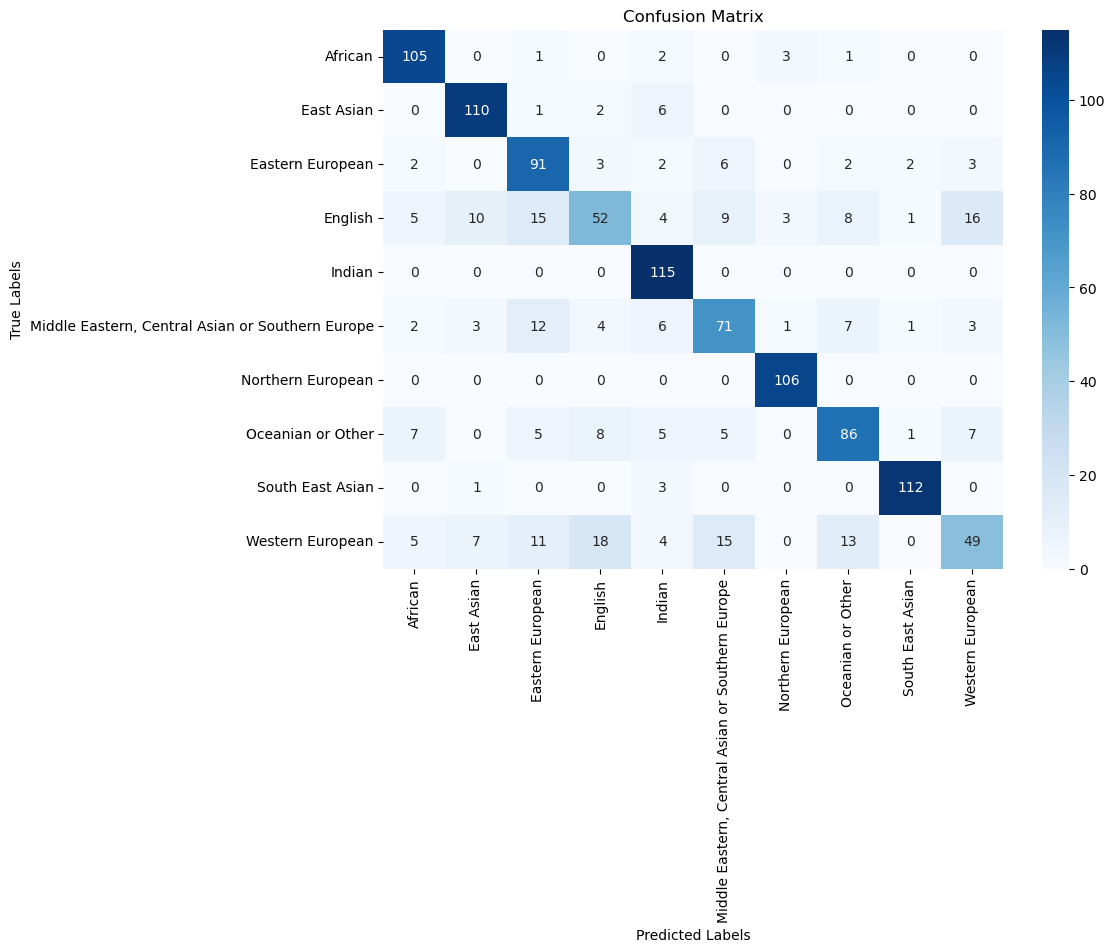

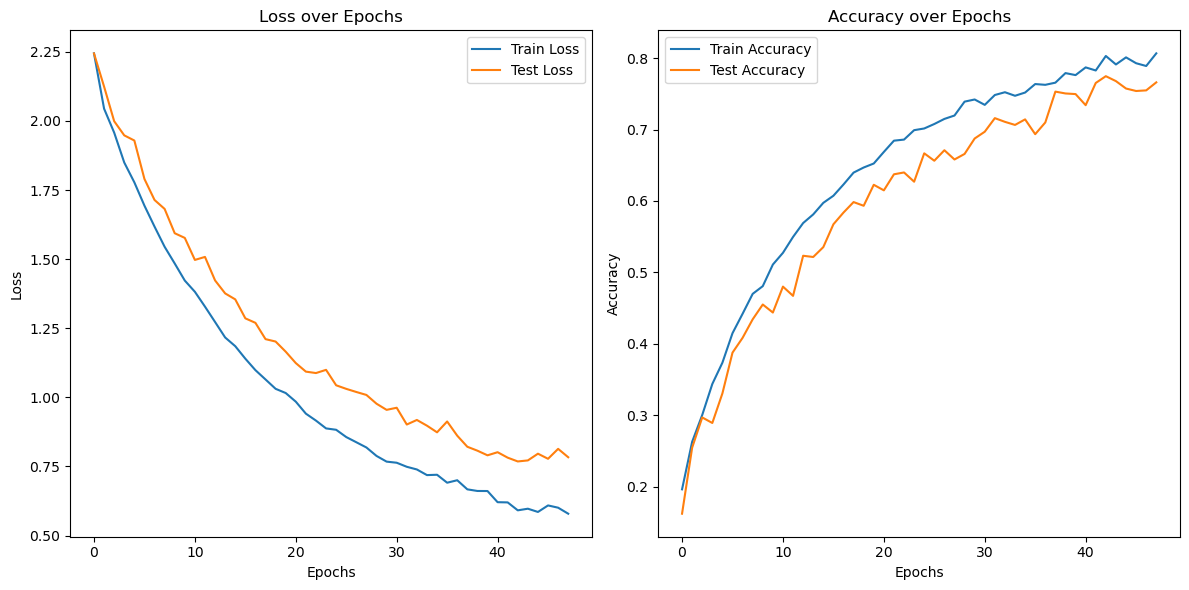

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class for the sample: Western European


In [90]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Menggunakan np.argmax untuk mendapatkan kelas dengan probabilitas tertinggi
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Ambil kelas dengan probabilitas tertinggi

# Menggunakan label_encoder untuk mengonversi y_test kembali ke label integer jika diperlukan
# Misalnya y_test sudah ter-encode, maka kita bisa langsung menggunakan y_test
# Pastikan y_test adalah integer encoded labels, bukan one-hot
# Misalnya, jika y_test sudah berupa integer (hasil transformasi dengan LabelEncoder), kita bisa menggunakan langsung.

y_test_int = label_encoder.transform(y_test)  # Mengubah y_test menjadi integer encoded jika diperlukan

# Menghitung akurasi prediksi
accuracy_pred = accuracy_score(y_test_int, y_pred)
print(f"Predicted Accuracy: {accuracy_pred}")

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot Training and Testing Loss & Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Contoh prediksi untuk sample dari X_test
sample_index = 0  # Ambil indeks sample pertama
sample = X_test[sample_index].reshape(1, X_test.shape[1], 1)  # Reshape untuk input model

# Prediksi label untuk sample
predicted_label = model.predict(sample)
predicted_class = label_encoder.inverse_transform([np.argmax(predicted_label)])

print(f"Predicted class for the sample: {predicted_class[0]}")

In [121]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Fungsi untuk mengekstrak MFCC dari file audio
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # Rata-rata untuk setiap koefisien MFCC
    return mfcc_mean

# Path ke file audio yang ingin diprediksi
example_file =os.getcwd() + '/kaggle/input/recordings/recordings/arabic30.mp3'

# Ekstraksi fitur MFCC dari file audio
mfcc_features = extract_mfcc(example_file)

# Reshape untuk menyesuaikan dengan input model (1, n_features, 1)
mfcc_features_reshaped = mfcc_features.reshape(1, mfcc_features.shape[0], 1)

# Memuat model yang sudah dilatih (misalnya model yang telah disimpan sebelumnya)
# Jika model sudah dilatih sebelumnya, muat model dengan cara ini:
  # Gantilah dengan path model Anda jika sudah disimpan

# Lakukan prediksi
predicted_prob = model.predict(mfcc_features_reshaped)
predicted_class = np.argmax(predicted_prob, axis=1)

# Mengonversi hasil prediksi kembali ke label asli menggunakan LabelEncoder
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted label for the audio file: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted label for the audio file: Middle Eastern, Central Asian or Southern Europe


In [104]:
max(predicted_prob[0])

0.9808164

In [119]:
import requests
def download_video(url, save_path):
    headers = {
        "User-Agent": "Mozilla/5.0",  # mimic a real browser
        "Accept": "*/*",
        "Connection": "keep-alive"
    }
    response = requests.get(url, stream=True, headers=headers)
    response.raise_for_status()
    with open(save_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

video_url = 'https://files.catbox.moe/3ar9d9.mp4'
output_filename = 'video.mp4'
download_video(video_url,output_filename)


from moviepy import VideoFileClip
cvt_video = VideoFileClip("video.mp4")
ext_audio = cvt_video.audio

ext_audio.write_audiofile("audio.mp3")

MoviePy - Writing audio in audio.mp3


MoviePy - Done.


In [129]:
# Fungsi untuk mengekstrak MFCC dari file audio
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # Rata-rata untuk setiap koefisien MFCC
    return mfcc_mean

# Path ke file audio yang ingin diprediksi
example_file =os.getcwd() + '/kaggle/input/recordings/recordings/arabic30.mp3'

# Ekstraksi fitur MFCC dari file audio
mfcc_features = extract_mfcc("audio.mp3")

# Reshape untuk menyesuaikan dengan input model (1, n_features, 1)
mfcc_features_reshaped = mfcc_features.reshape(1, mfcc_features.shape[0], 1)

# Memuat model yang sudah dilatih (misalnya model yang telah disimpan sebelumnya)
# Jika model sudah dilatih sebelumnya, muat model dengan cara ini:
  # Gantilah dengan path model Anda jika sudah disimpan

# Lakukan prediksi
predicted_prob = model.predict(mfcc_features_reshaped)
predicted_class = np.argmax(predicted_prob, axis=1)

# Mengonversi hasil prediksi kembali ke label asli menggunakan LabelEncoder
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted label for the audio file: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted label for the audio file: Eastern European


In [130]:
import pickle
file = './NN_Accent_prediction.pkl'
with open(file, 'wb') as f:
    pickle.dump(model, f)

In [131]:
max(predicted_prob[0])

0.5783927

In [132]:
filename = 'label_encoder.pkl'
pickle.dump(label_encoder, open(filename, 'wb'))